## Project Overview and Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 19, 9

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.4.1


## Load and Inspect the S&P 500 Index Data

[Data Source](https://www.kaggle.com/pdquant/sp500-daily-19862018): S&P500 Daily Prices 1986 - 2018

In [3]:
path = "enterdatapath"
df = pd.read_csv(path, parse_dates=['date'])
df.sample(3)

,date,close
4478,2003-09-30,995.97
4889,2005-05-18,1185.56
8041,2017-11-22,2597.08


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8192 entries, 0 to 8191
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    8192 non-null   datetime64[ns]
 1   close   8192 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 128.1 KB


In [5]:
figure = go.Figure()
figure.add_trace(go.Scatter
                 (
                     x = df['date'], y = df['close'],
                     mode = 'lines', name = 'close'
                 ))
figure.update_layout(showlegend = True)
figure.show()

## Data Preprocessing

In [6]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train_df, test_df = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Training df shape :', train_df.shape)
print('Test df shape: ', test_df.shape)

Training df shape : (6553, 2)
Test df shape:  (1639, 2)


In [7]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
close,6553.0,842.210629,417.29523,203.49,414.84,920.77,1210.13,1565.15


In [8]:
scaler = StandardScaler()
scaler = scaler.fit(train_df[['close']])

train_df['close'] = scaler.transform(train_df[['close']])
test_df['close'] = scaler.transform(test_df[['close']])

print(train_df.sample(3))
print(test_df.sample(3))

           date     close
576  1988-04-13 -1.367579
4445 2003-08-13  0.339880
374  1987-06-25 -1.277971
           date     close
7247 2014-09-30  2.708312
7772 2016-10-28  3.077671
7883 2017-04-10  3.630679


In [9]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
close,6553.0,2.641968e-16,1.000076,-1.530737,-1.024223,0.188273,0.881744,1.732573


## Create Training and Test Splits

In [10]:
def create_dataset(x, y, time_steps=1):
    xs, ys = [], []
    for i in range(len(x) - time_steps):
        v = x.iloc[i:(i + time_steps)].values
        xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(xs), np.array(ys)

In [11]:
time_steps = 30

x_train, y_train = create_dataset(train_df['close'], train_df['close'], time_steps)
x_test, y_test = create_dataset(test_df['close'], test_df['close'], time_steps)

x_train = np.expand_dims(x_train, 2)
x_test = np.expand_dims(x_test, 2)


print('Training df shape :', x_train.shape)
print('Test df shape: ', x_test.shape)

Training df shape : (6523, 30, 1)
Test df shape:  (1609, 30, 1)


## Build an LSTM Autoencoder

In [12]:
timesteps = x_train.shape[1]
num_features = x_train.shape[2]
print(timesteps)
print(num_features)

30
1


In [22]:
# Simple LSTM Autoencoder
# Timesteps = 30 and num of features = 1

model = Sequential([
        LSTM(312, input_shape = (timesteps,num_features)),
        Dropout(0.2),
        RepeatVector(timesteps),
        LSTM(312, return_sequences=True),
        Dropout(0.2),
        TimeDistributed(Dense(num_features))            
])
opt = tf.keras.optimizers.Adam(lr = 0.0008)
model.compile(loss = 'mae', optimizer = opt)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 312)               391872    
_________________________________________________________________
dropout_8 (Dropout)          (None, 312)               0         
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 30, 312)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 30, 312)           780000    
_________________________________________________________________
dropout_9 (Dropout)          (None, 30, 312)           0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 1)             313       
Total params: 1,172,185
Trainable params: 1,172,185
Non-trainable params: 0
____________________________________________

## Train the Autoencoder

In [23]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose = 1)
lr_sc = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience = 2,
                                             factor = np.sqrt(0.1), verbose = 1)
history = model.fit(
    x_train, y_train,
    epochs=64,
    validation_split=0.1,
    callbacks = [es,lr_sc],
    shuffle=False # order of data matters
)

Epoch 1/64
184/184 [==============================] - 5s 11ms/step - loss: 0.1811 - val_loss: 0.2058
Epoch 2/64
184/184 [==============================] - 1s 7ms/step - loss: 0.1382 - val_loss: 0.1243
Epoch 3/64
184/184 [==============================] - 1s 8ms/step - loss: 0.0995 - val_loss: 0.1043
Epoch 4/64
184/184 [==============================] - 1s 7ms/step - loss: 0.0958 - val_loss: 0.1214
Epoch 5/64
184/184 [==============================] - 1s 7ms/step - loss: 0.0954 - val_loss: 0.1131

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002529822064226021.
Epoch 6/64
184/184 [==============================] - 1s 8ms/step - loss: 0.1105 - val_loss: 0.0391
Epoch 7/64
184/184 [==============================] - 1s 7ms/step - loss: 0.0445 - val_loss: 0.0400
Epoch 8/64
184/184 [==============================] - 1s 7ms/step - loss: 0.0476 - val_loss: 0.0332
Epoch 9/64
184/184 [==============================] - 1s 7ms/step - loss: 0.0478 - val_loss: 0.0303
Epoch 10/64
184/18

## Plot Metrics and Evaluate the Model

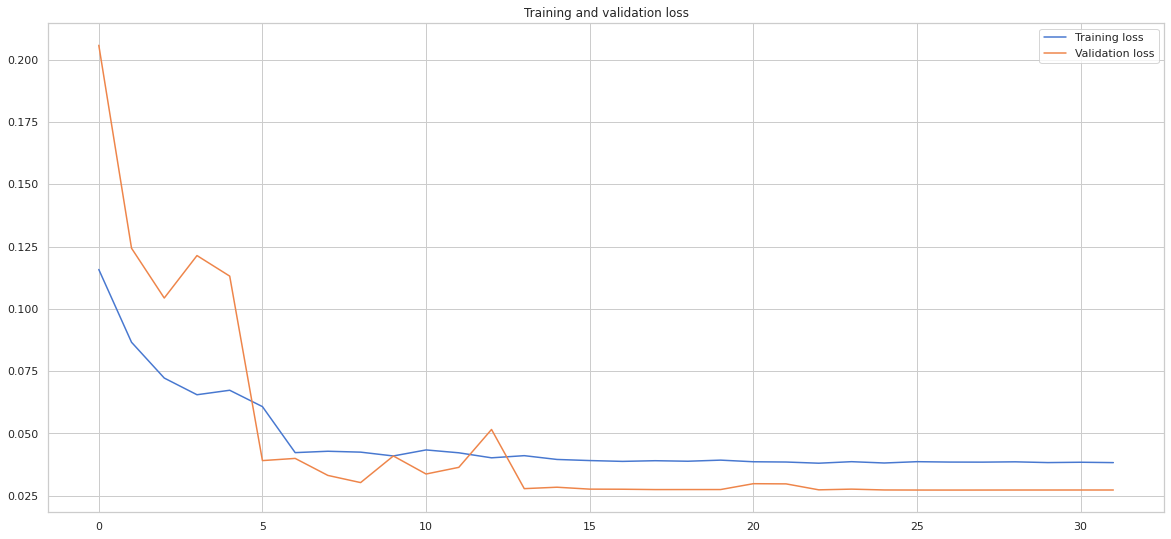

In [24]:
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------

loss = history.history['loss' ]
val_loss = history.history['val_loss' ]

epochs = range(len(loss)) # Get number of epochs

plt.figure(figsize = (20,9))
plt.plot( epochs, loss, label = 'Training loss')
plt.plot( epochs, val_loss, label = 'Validation loss')
plt.title ('Training and validation loss')
plt.legend()

In [25]:
model.evaluate(x_test, y_test, steps= 24, batch_size = 64)

24/24 [==============================] - 0s 7ms/step - loss: 0.1747


0.17472679913043976

In [26]:
x_train_pred = model.predict(x_train)
train_mae_loss = pd.DataFrame(np.mean(np.abs(x_train_pred - x_train), axis=1), columns=['Error'])

x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

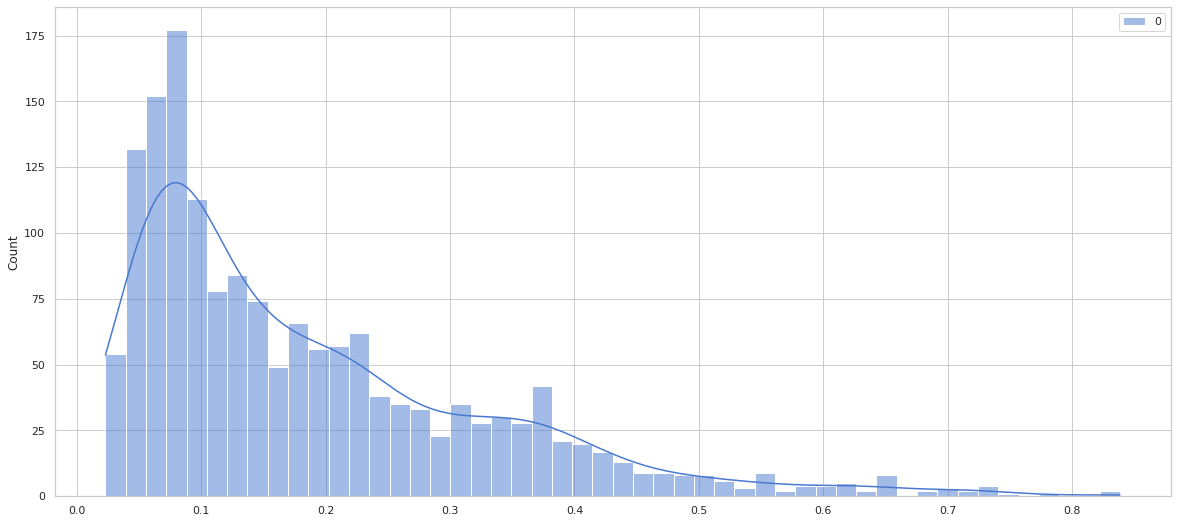

In [27]:
# Distribution of test loss
plt.figure(figsize = (20,9))
sns.histplot(test_mae_loss, bins=50, kde=True);

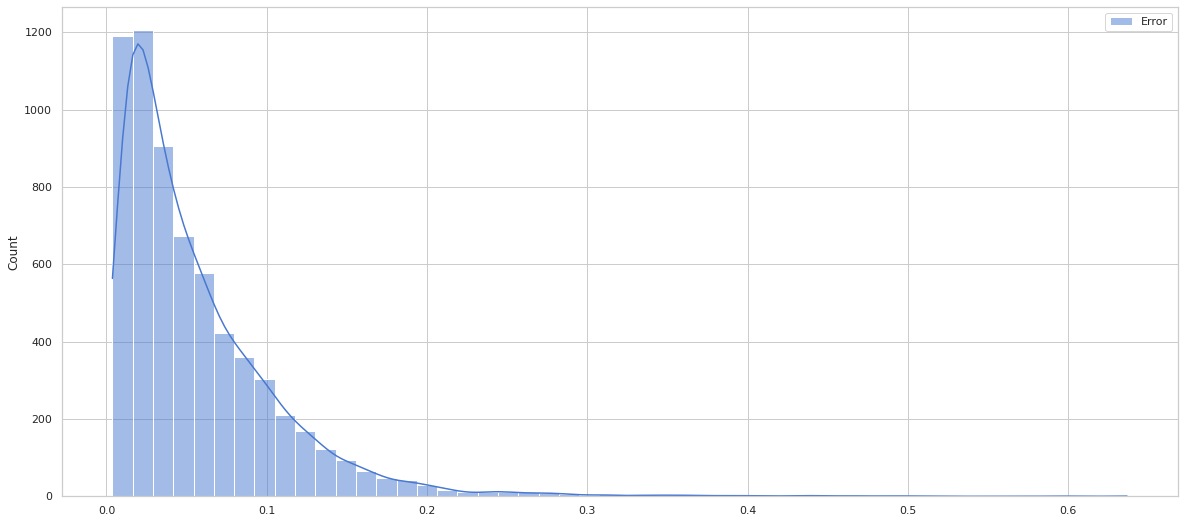

In [28]:
# Distribution of training loss
plt.figure(figsize = (20,9))
sns.histplot(train_mae_loss, bins=50, kde=True);

## Detect Anomalies in the S&P 500 Index Data

In [29]:
THRESHOLD = 0.7

test_score_df = pd.DataFrame(test_df[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test_df[time_steps:].close

In [30]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_df[time_steps:].date, y=test_score_df.loss,
                    mode='lines',
                    name='Test Loss'))
fig.add_trace(go.Scatter(x=test_df[time_steps:].date, y=test_score_df.threshold,
                    mode='lines',
                    name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()

In [31]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies

,date,close,loss,threshold,anomaly
8091,2018-02-06,4.440671,0.703155,0.7,True
8092,2018-02-07,4.408365,0.717921,0.7,True
8093,2018-02-08,4.167127,0.731267,0.7,True
8094,2018-02-09,4.259514,0.838386,0.7,True
8095,2018-02-12,4.346869,0.837568,0.7,True
8096,2018-02-13,4.363501,0.788933,0.7,True
8097,2018-02-14,4.449035,0.756142,0.7,True
8098,2018-02-15,4.527091,0.701586,0.7,True
8124,2018-03-26,4.352980,0.725842,0.7,True
8126,2018-03-28,4.224644,0.713215,0.7,True


In [32]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_df[time_steps:].date, y=scaler.inverse_transform(test_df[time_steps:].close),
                    mode='lines',
                    name='Close Price'))
fig.add_trace(go.Scatter(x=anomalies.date, y=scaler.inverse_transform(anomalies.close),
                    mode='markers',
                    name='Anomaly'))
fig.update_layout(showlegend=True)
fig.show()